<a href="https://colab.research.google.com/github/karlredgate/notebooks/blob/main/Airbnb_Open_Data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# New York Airbnb Open Data 2019

Quick data exploration tutorial showing the powerful combination of Google Sheets and CoLab Notebooks. 

###Setting up the notebook environment

To set up the notebook environment we'll use the same example code that Google provides in their __[External data: Local Files, Drive Sheets, and Cloud Storage](https://colab.research.google.com/notebooks/io.ipynb#scrollTo=sOm9PFrT8mGG)__ walkthrough notebook under the section __[Google Sheets](https://colab.research.google.com/notebooks/io.ipynb#scrollTo=sOm9PFrT8mGG)__. The code basically handles authentication and imports the ```gspread``` library which will allow you to communicate with Google Sheets. After running the cell you'll be prompted to enter in some credentials, which Google will give you by following the link provided. 

In [ ]:
from google.colab import auth
auth.authenticate_user()

import gspread
from oauth2client.client import GoogleCredentials

gc = gspread.authorize(GoogleCredentials.get_application_default())

Let's go ahead and add some popular Python imports in there as well:

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

### Importing the data

Now that we have the environment set up lets bring in some data. The data we'll be looking at was found on __[Kaggle](https://www.kaggle.com)__, which is an excelent resource for any aspiring data specialist. The dataset shows listings and metrics for Airbnb listing in New York City in 2019. You can download the dataset through __[this link](https://www.kaggle.com/dgomonov/new-york-city-airbnb-open-data)__. After you've downloaded the dataset (it will be in .csv format), upload it to your Google Drive. Then you can right-click on the file and select "open with Google Sheets". 

The ```gspread``` library makes it incredibly easy to communicate with Google Sheets, all you need is the URL. By convention, I generally call the workbook object ```wb```. To access the Google Sheet you can just use the ```gspread``` ```open_by_url()``` function, which you can access by the ```gc``` object you defined above. 

In [ ]:
wb = gc.open_by_url('https://docs.google.com/spreadsheets/d/1YTD0pxdGTGAzM8IiWDfLL4AZPjrFRN-vpGUiLQWOtoI/edit#gid=1512387781')

Now that we have the workbook object we can call specific sheets from the workbook. For the workbook we're working with there's only one sheet which makes this really easy but if your workbook had for instance 10 different tabs it would be nice to know how to call one specific sheet. You can do this by calling the ```worksheet()``` function off of the workbook object (that we called ```wb```). You can see this below:

In [ ]:
sheet = wb.worksheet('AB_NYC_2019')

Now that we have the specific sheet you'll notice that if you just call the ```sheet``` variable above it will just return something along the lines of ```<Worksheet 'AB_NYC_2019' id:0012387781>```. That's becuase now that we have our sheet variable we need to extract all of the values from that sheet. To do this we just call ```get_all_values()``` on the worksheet object.

In [ ]:
data = sheet.get_all_values()

After getting all of the values from the sheet you'll see that if you call ```data``` that we just created you'll just get back a list. This seems annoying but the list type of the data makes it versatile enough to use in many different ways. For this walkthough we'll make it usable by converting it into a Pandas DataFrame. 

In [ ]:
df = pd.DataFrame(data)
df.columns = df.iloc[0]
df = df.iloc[1:]

In [ ]:
df.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
1,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365
2,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
3,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.9419,Private room,150,3,0,,,1,365
4,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
5,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.1,1,0


If you look at the table above you'll notice that some of the columns aren't useful for our analysis (i.e. ```id```, ```name```, ```host_id```, and ```host_name```) so we can get rid of those to simplify the table. Also, something that isn't apparent just yet but will definitely cause a problem down the road is the the values returned when using the ```gspread``` library actually give you string types instead of floats or ints as you can see below: 

In [ ]:
# looking at the return type for the first row of the latitude column

type(df.iloc[0][6])

str

Unfortunately this is something that always creates a sort of bottleneck for me when working with ```gspread``` and Google sheets. There are some work arounds which I'll get into below but I really hope they make the library a little more user friendly so that it will take care of these issues automatically without you having to worry about it. 

Since we have to get rid of some rows anyways this gives us an excuse to set up our own table with a schema we get to create letting us have more control as well as help fix the type issue. 

First, we need to fix the issue of missing values in the ```reviews_per_month``` column. We can do this by using an ```apply()``` function and a lambda statement saying if the value of the cell in the column is equal to ```''``` then we replace it with ```'0'```. This way we can use the same fix we will use for other columns (simply using the ```astype()``` function) to easily convert the values from floats to strings in the columns. 

In [ ]:
# creating a new column with '0' values instead of '' for reviews per month

df['reviews_per_month_new'] = df['reviews_per_month'].apply(lambda x: '0' if x == '' else x)

In [ ]:
# creating a dictionary with our determined schema

new_df_schema = {
    'Neighborhood Group': df['neighbourhood_group'].astype(str),
    'Neighborhood': df['neighbourhood'].astype(str),
    'Latitude': df['latitude'].astype(float),
    'Longitude': df['longitude'].astype(float),
    'Room Type': df['room_type'].astype(str),
    'Price': df['price'].astype(float),
    'Minimum Nights': df['minimum_nights'].astype(int),
    'Number of Reviews': df['number_of_reviews'].astype(int),
    'Reviews Per Month': df['reviews_per_month_new'].astype(float)
}

Now that we have the new schema determined we can convert the dict above into a new Pandas DataFrame that we can now use to analyze and visualize the data. 

In [ ]:
airbnb_ny_df = pd.DataFrame(new_df_schema)

In [ ]:
airbnb_ny_df.head()

,Neighborhood Group,Neighborhood,Latitude,Longitude,Room Type,Price,Minimum Nights,Number of Reviews,Reviews Per Month
1,Brooklyn,Kensington,40.64749,-73.97237,Private room,149.0,1,9,0.21
2,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225.0,1,45,0.38
3,Manhattan,Harlem,40.80902,-73.94190,Private room,150.0,3,0,0.00
4,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89.0,1,270,4.64
5,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80.0,10,9,0.10


Doesn't this look so much better? More human readable headers, determined types for each column, and just overall much more manageable. 

Now that we have a nice dataframe to work with lets start anlyzing the data. 

### Basic Analysis

Since this is mostly about showing off the power of __Google Sheets__ and __Colab__ I won't go over as much about the thought process for the analysis but just show some of the basic insights and visualizations you can get with just a few lines of code.

In [ ]:
#@title Most popular neighborhood group for Airbnbs in New York

airbnb_ny_df['Neighborhood Group'].describe()

count         48895
unique            5
top       Manhattan
freq          21661
Name: Neighborhood Group, dtype: object

In [ ]:
#@title Most popular neighborhood for Airbnbs in New York

airbnb_ny_df['Neighborhood'].describe()

count            48895
unique             221
top       Williamsburg
freq              3920
Name: Neighborhood, dtype: object

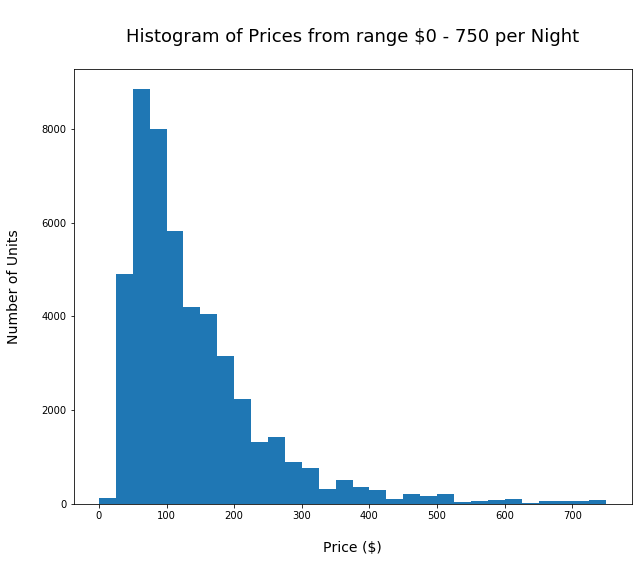

In [ ]:
#@title Unit pricing per night adjusted to not include outliers

plt.figure(figsize=(10,8))
plt.hist(airbnb_ny_df['Price'], bins=30, range=(0, 750))
plt.title('\nHistogram of Prices from range \\$0 - 750 per Night\n', fontsize=18)
plt.ylabel('Number of Units\n', fontsize=14)
plt.xlabel('\nPrice ($)', fontsize=14)
plt.show()

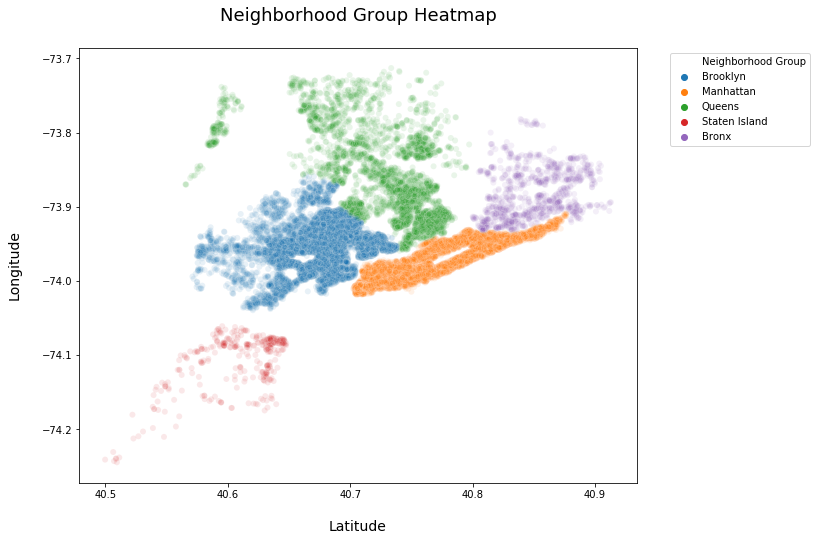

In [ ]:
#@title Visualizing neighborhood group density

import seaborn as sns

plt.figure(figsize=(10,8))
sns.scatterplot(x=airbnb_ny_df['Latitude'],
               y=airbnb_ny_df['Longitude'],
                hue=airbnb_ny_df['Neighborhood Group'],
                alpha=0.1)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2)
plt.title('Neighborhood Group Heatmap\n', fontsize=18)
plt.ylabel('Longitude\n', fontsize=14)
plt.xlabel('\nLatitude', fontsize=14)
plt.show()

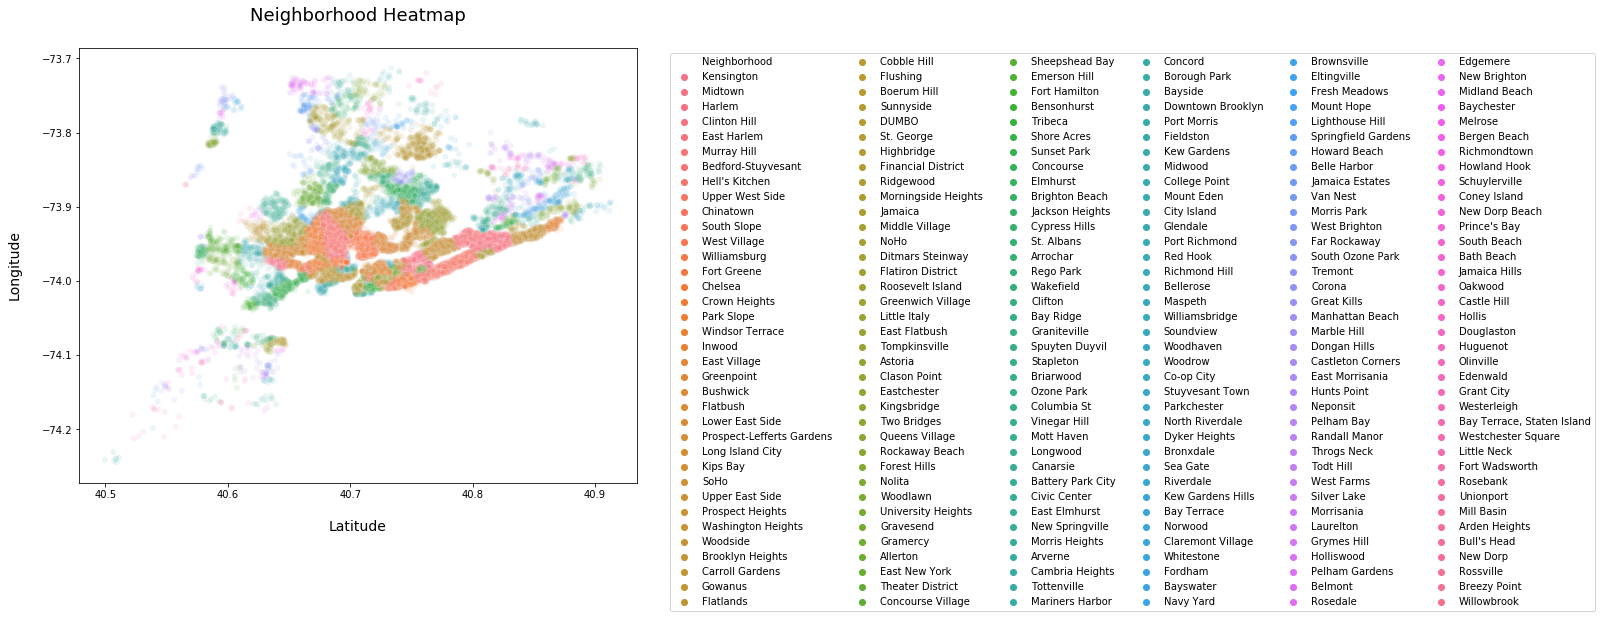

In [ ]:
#@title Visualizing neighborhood density

plt.figure(figsize=(10,8))
sns.scatterplot(x=airbnb_ny_df['Latitude'],
               y=airbnb_ny_df['Longitude'],
                hue=airbnb_ny_df['Neighborhood'],
                alpha=0.1)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, ncol=6)
plt.title('Neighborhood Heatmap\n', fontsize=18)
plt.ylabel('Longitude\n', fontsize=14)
plt.xlabel('\nLatitude', fontsize=14)
plt.show()